In [63]:
import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
)
from PIL import Image, ImageDraw

from monai.visualize import plot_2d_or_3d_image
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Tuple
from monai.transforms.utils import rescale_array
from os import mkdir
from os.path import isdir



In [64]:
print(monai.__version__)

ROOT_EXP   = '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/'
EXPERIMENT = 'synthetic/' # 'synthetic', 'ISLES', 'BRATS'
ROOT_DATA  = 'data/'+EXPERIMENT

if( not isdir(ROOT_EXP+"/models/"+EXPERIMENT)):
    mkdir(ROOT_EXP+"/models/"+EXPERIMENT)
    
#At insel: /home/sebastian/experiments/fedem/data/'

0.8.0


In [65]:
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

MONAI version: 0.8.0
Numpy version: 1.20.3
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.3.1
Tensorboard version: 2.7.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.1
tqdm version: 4.62.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.3.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.11.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [66]:
train_dir = ROOT_DATA + 'train/'
val_dir   = ROOT_DATA + 'val/'
test_dir  = ROOT_DATA + 'test/'

# First Silo (SQUARES)

In [67]:
imagepaths_train  = sorted(glob(os.path.join(train_dir, "square*img*.png")))
segmpaths_train   = sorted(glob(os.path.join(train_dir, "square*seg*.png")))
print(len(imagepaths_train),len(segmpaths_train))

imagepaths_val  = sorted(glob(os.path.join(val_dir, "square*img*.png")))
segmpaths_val   = sorted(glob(os.path.join(val_dir, "square*seg*.png")))
print(len(imagepaths_val),len(segmpaths_val))

imagepaths_test  = sorted(glob(os.path.join(test_dir, "*img*.png")))
segmpaths_test   = sorted(glob(os.path.join(test_dir, "*seg*.png")))
print(len(imagepaths_test),len(segmpaths_test))

OUTPUT = ROOT_EXP + 'results_distributed_squares/'

if(not isdir(OUTPUT)):
    mkdir(OUTPUT)
    

25 25
5 5
20 20


In [68]:
imagepaths_train

['data/synthetic/train/square_img15.png',
 'data/synthetic/train/square_img16.png',
 'data/synthetic/train/square_img17.png',
 'data/synthetic/train/square_img18.png',
 'data/synthetic/train/square_img19.png',
 'data/synthetic/train/square_img20.png',
 'data/synthetic/train/square_img21.png',
 'data/synthetic/train/square_img22.png',
 'data/synthetic/train/square_img23.png',
 'data/synthetic/train/square_img24.png',
 'data/synthetic/train/square_img25.png',
 'data/synthetic/train/square_img26.png',
 'data/synthetic/train/square_img27.png',
 'data/synthetic/train/square_img28.png',
 'data/synthetic/train/square_img29.png',
 'data/synthetic/train/square_img30.png',
 'data/synthetic/train/square_img31.png',
 'data/synthetic/train/square_img32.png',
 'data/synthetic/train/square_img33.png',
 'data/synthetic/train/square_img34.png',
 'data/synthetic/train/square_img35.png',
 'data/synthetic/train/square_img36.png',
 'data/synthetic/train/square_img37.png',
 'data/synthetic/train/square_img3

In [69]:
# define transforms for image and segmentation
train_imtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)
train_segtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)

In [70]:
val_imtrans  = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])
val_segtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

# define array dataset, data loader
check_ds     =    ArrayDataset(imagepaths_train, train_imtrans, segmpaths_train, train_segtrans)
check_loader = DataLoader(check_ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg      =  monai.utils.misc.first(check_loader)
print(im.shape, seg.shape)

torch.Size([10, 1, 96, 96]) torch.Size([10, 1, 96, 96])


In [71]:
# create a training data loader
train_ds = ArrayDataset(imagepaths_train, train_imtrans, segmpaths_train, train_segtrans)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available()
                         )
# create a validation data loader
val_ds = ArrayDataset(imagepaths_val, val_imtrans, segmpaths_val, val_segtrans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())

#create the test data loader
test_ds = ArrayDataset(imagepaths_test, val_imtrans, segmpaths_test, val_segtrans)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
dice_metric_test = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)


post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


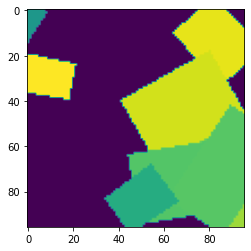

In [72]:
plt.imshow(train_ds[0][0][0].cpu())

Training for run 0
----------
epoch 1/10
1/6, train_loss: 0.4882
2/6, train_loss: 0.5082
3/6, train_loss: 0.5001
4/6, train_loss: 0.5152
5/6, train_loss: 0.4932
6/6, train_loss: 0.4812
7/6, train_loss: 0.4599
epoch 1 average loss: 0.4923
----------
epoch 2/10
1/6, train_loss: 0.4546
2/6, train_loss: 0.4822
3/6, train_loss: 0.4274
4/6, train_loss: 0.4566
5/6, train_loss: 0.4386
6/6, train_loss: 0.4548
7/6, train_loss: 0.3550
epoch 2 average loss: 0.4384
saved new best metric model
current epoch: 2 current mean dice: 0.5049 best mean dice: 0.5049 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.4580
2/6, train_loss: 0.4138
3/6, train_loss: 0.4280
4/6, train_loss: 0.4748
5/6, train_loss: 0.4333
6/6, train_loss: 0.4429
7/6, train_loss: 0.4410
epoch 3 average loss: 0.4417
----------
epoch 4/10
1/6, train_loss: 0.4238
2/6, train_loss: 0.4244
3/6, train_loss: 0.3915
4/6, train_loss: 0.4748
5/6, train_loss: 0.3967
6/6, train_loss: 0.3990
7/6, train_loss: 0.4534
epoch 4 average loss: 0.4234


1/6, train_loss: 0.2612
2/6, train_loss: 0.2350
3/6, train_loss: 0.2594
4/6, train_loss: 0.2587
5/6, train_loss: 0.2372
6/6, train_loss: 0.2626
7/6, train_loss: 0.1764
epoch 31 average loss: 0.2415
----------
epoch 32/10
1/6, train_loss: 0.2320
2/6, train_loss: 0.2824
3/6, train_loss: 0.2255
4/6, train_loss: 0.3129
5/6, train_loss: 0.2418
6/6, train_loss: 0.2381
7/6, train_loss: 0.2043
epoch 32 average loss: 0.2482
saved new best metric model
current epoch: 32 current mean dice: 0.9747 best mean dice: 0.9747 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.2714
2/6, train_loss: 0.2604
3/6, train_loss: 0.2254
4/6, train_loss: 0.2674
5/6, train_loss: 0.2182
6/6, train_loss: 0.2010
7/6, train_loss: 0.2192
epoch 33 average loss: 0.2376
----------
epoch 34/10
1/6, train_loss: 0.2484
2/6, train_loss: 0.2461
3/6, train_loss: 0.2309
4/6, train_loss: 0.2064
5/6, train_loss: 0.2555
6/6, train_loss: 0.2324
7/6, train_loss: 0.1550
epoch 34 average loss: 0.2250
saved new best metric model
curr

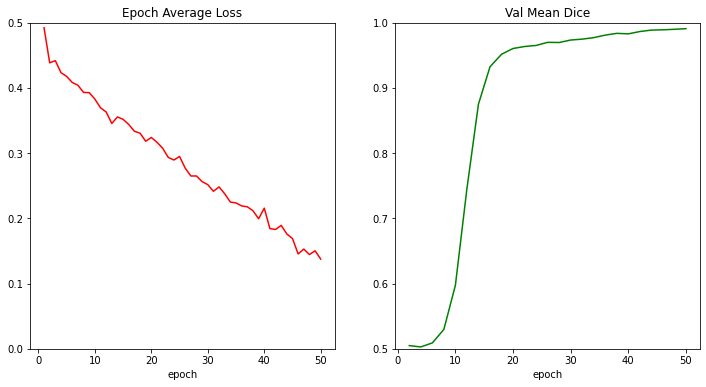

Dice in Test partition for run 00.9980753660202026
Training for run 1
----------
epoch 1/10
1/6, train_loss: 0.4845
2/6, train_loss: 0.4663
3/6, train_loss: 0.3939
4/6, train_loss: 0.3680
5/6, train_loss: 0.3825
6/6, train_loss: 0.3888
7/6, train_loss: 0.3463
epoch 1 average loss: 0.4043
----------
epoch 2/10
1/6, train_loss: 0.3567
2/6, train_loss: 0.3048
3/6, train_loss: 0.3341
4/6, train_loss: 0.3122
5/6, train_loss: 0.2914
6/6, train_loss: 0.3174
7/6, train_loss: 0.3654
epoch 2 average loss: 0.3260
saved new best metric model
current epoch: 2 current mean dice: 0.9430 best mean dice: 0.9430 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.2779
2/6, train_loss: 0.3354
3/6, train_loss: 0.3143
4/6, train_loss: 0.2784
5/6, train_loss: 0.2814
6/6, train_loss: 0.2914
7/6, train_loss: 0.3189
epoch 3 average loss: 0.2997
----------
epoch 4/10
1/6, train_loss: 0.3097
2/6, train_loss: 0.3346
3/6, train_loss: 0.2989
4/6, train_loss: 0.3201
5/6, train_loss: 0.2813
6/6, train_loss: 0.2536
7/

1/6, train_loss: 0.1430
2/6, train_loss: 0.1141
3/6, train_loss: 0.1476
4/6, train_loss: 0.1300
5/6, train_loss: 0.1227
6/6, train_loss: 0.1261
7/6, train_loss: 0.1646
epoch 31 average loss: 0.1354
----------
epoch 32/10
1/6, train_loss: 0.1391
2/6, train_loss: 0.1509
3/6, train_loss: 0.1802
4/6, train_loss: 0.1401
5/6, train_loss: 0.1061
6/6, train_loss: 0.1785
7/6, train_loss: 0.1186
epoch 32 average loss: 0.1448
saved new best metric model
current epoch: 32 current mean dice: 0.9838 best mean dice: 0.9838 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.1602
2/6, train_loss: 0.1503
3/6, train_loss: 0.1281
4/6, train_loss: 0.1421
5/6, train_loss: 0.1402
6/6, train_loss: 0.1253
7/6, train_loss: 0.1539
epoch 33 average loss: 0.1429
----------
epoch 34/10
1/6, train_loss: 0.1611
2/6, train_loss: 0.1797
3/6, train_loss: 0.1587
4/6, train_loss: 0.1453
5/6, train_loss: 0.1048
6/6, train_loss: 0.1165
7/6, train_loss: 0.1495
epoch 34 average loss: 0.1451
saved new best metric model
curr

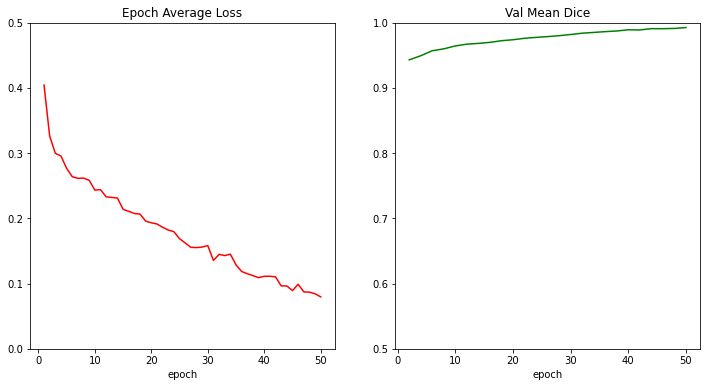

Dice in Test partition for run 10.9975147247314453
Training for run 2
----------
epoch 1/10
1/6, train_loss: 0.5217
2/6, train_loss: 0.5227
3/6, train_loss: 0.4789
4/6, train_loss: 0.4660
5/6, train_loss: 0.4578
6/6, train_loss: 0.4074
7/6, train_loss: 0.4538
epoch 1 average loss: 0.4726
----------
epoch 2/10
1/6, train_loss: 0.4624
2/6, train_loss: 0.4481
3/6, train_loss: 0.3761
4/6, train_loss: 0.4270
5/6, train_loss: 0.4145
6/6, train_loss: 0.3777
7/6, train_loss: 0.3992
epoch 2 average loss: 0.4150
saved new best metric model
current epoch: 2 current mean dice: 0.5105 best mean dice: 0.5105 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.4108
2/6, train_loss: 0.4073
3/6, train_loss: 0.3824
4/6, train_loss: 0.3879
5/6, train_loss: 0.3835
6/6, train_loss: 0.4145
7/6, train_loss: 0.3810
epoch 3 average loss: 0.3953
----------
epoch 4/10
1/6, train_loss: 0.4027
2/6, train_loss: 0.3747
3/6, train_loss: 0.3927
4/6, train_loss: 0.3825
5/6, train_loss: 0.4151
6/6, train_loss: 0.3537
7/

1/6, train_loss: 0.2237
2/6, train_loss: 0.3076
3/6, train_loss: 0.2094
4/6, train_loss: 0.2209
5/6, train_loss: 0.1918
6/6, train_loss: 0.2511
7/6, train_loss: 0.2366
epoch 31 average loss: 0.2344
----------
epoch 32/10
1/6, train_loss: 0.1966
2/6, train_loss: 0.2528
3/6, train_loss: 0.1828
4/6, train_loss: 0.2478
5/6, train_loss: 0.2284
6/6, train_loss: 0.1764
7/6, train_loss: 0.2638
epoch 32 average loss: 0.2212
saved new best metric model
current epoch: 32 current mean dice: 0.9682 best mean dice: 0.9682 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.2287
2/6, train_loss: 0.2219
3/6, train_loss: 0.2243
4/6, train_loss: 0.1891
5/6, train_loss: 0.1702
6/6, train_loss: 0.1963
7/6, train_loss: 0.1472
epoch 33 average loss: 0.1968
----------
epoch 34/10
1/6, train_loss: 0.2152
2/6, train_loss: 0.2087
3/6, train_loss: 0.2253
4/6, train_loss: 0.1545
5/6, train_loss: 0.1873
6/6, train_loss: 0.2215
7/6, train_loss: 0.1679
epoch 34 average loss: 0.1972
saved new best metric model
curr

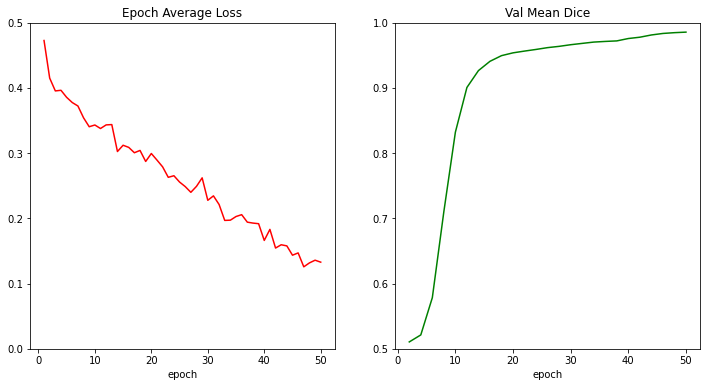

Dice in Test partition for run 20.9951815605163574
Training for run 3
----------
epoch 1/10
1/6, train_loss: 0.5080
2/6, train_loss: 0.4522
3/6, train_loss: 0.3980
4/6, train_loss: 0.4494
5/6, train_loss: 0.4022
6/6, train_loss: 0.4300
7/6, train_loss: 0.3875
epoch 1 average loss: 0.4325
----------
epoch 2/10
1/6, train_loss: 0.3719
2/6, train_loss: 0.3874
3/6, train_loss: 0.3883
4/6, train_loss: 0.3533
5/6, train_loss: 0.3562
6/6, train_loss: 0.3199
7/6, train_loss: 0.3612
epoch 2 average loss: 0.3626
saved new best metric model
current epoch: 2 current mean dice: 0.8088 best mean dice: 0.8088 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.4018
2/6, train_loss: 0.3567
3/6, train_loss: 0.3225
4/6, train_loss: 0.3310
5/6, train_loss: 0.3463
6/6, train_loss: 0.3240
7/6, train_loss: 0.2837
epoch 3 average loss: 0.3380
----------
epoch 4/10
1/6, train_loss: 0.3516
2/6, train_loss: 0.3076
3/6, train_loss: 0.3022
4/6, train_loss: 0.3303
5/6, train_loss: 0.3124
6/6, train_loss: 0.3235
7/

1/6, train_loss: 0.1648
2/6, train_loss: 0.1303
3/6, train_loss: 0.2533
4/6, train_loss: 0.1978
5/6, train_loss: 0.1768
6/6, train_loss: 0.1841
7/6, train_loss: 0.1756
epoch 31 average loss: 0.1833
----------
epoch 32/10
1/6, train_loss: 0.1554
2/6, train_loss: 0.1366
3/6, train_loss: 0.1748
4/6, train_loss: 0.1623
5/6, train_loss: 0.1728
6/6, train_loss: 0.1545
7/6, train_loss: 0.2704
epoch 32 average loss: 0.1753
saved new best metric model
current epoch: 32 current mean dice: 0.9793 best mean dice: 0.9793 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.1679
2/6, train_loss: 0.1481
3/6, train_loss: 0.1822
4/6, train_loss: 0.1447
5/6, train_loss: 0.2230
6/6, train_loss: 0.1899
7/6, train_loss: 0.1185
epoch 33 average loss: 0.1678
----------
epoch 34/10
1/6, train_loss: 0.1758
2/6, train_loss: 0.1695
3/6, train_loss: 0.1995
4/6, train_loss: 0.1627
5/6, train_loss: 0.1985
6/6, train_loss: 0.0953
7/6, train_loss: 0.1258
epoch 34 average loss: 0.1610
saved new best metric model
curr

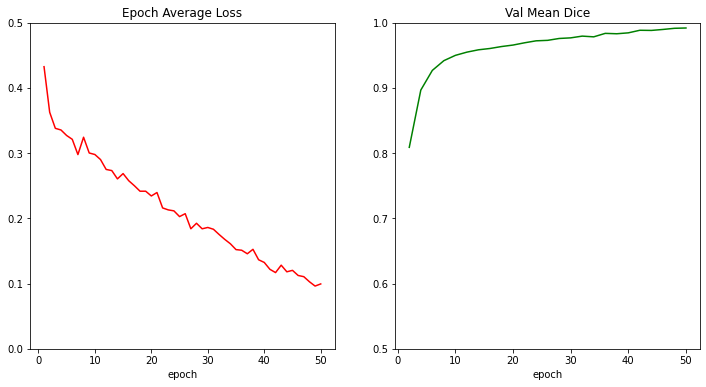

Dice in Test partition for run 30.9979149699211121
Training for run 4
----------
epoch 1/10
1/6, train_loss: 0.5419
2/6, train_loss: 0.4163
3/6, train_loss: 0.3769
4/6, train_loss: 0.3244
5/6, train_loss: 0.3397
6/6, train_loss: 0.3385
7/6, train_loss: 0.3051
epoch 1 average loss: 0.3776
----------
epoch 2/10
1/6, train_loss: 0.2949
2/6, train_loss: 0.3128
3/6, train_loss: 0.2682
4/6, train_loss: 0.3372
5/6, train_loss: 0.3290
6/6, train_loss: 0.3373
7/6, train_loss: 0.3214
epoch 2 average loss: 0.3144
saved new best metric model
current epoch: 2 current mean dice: 0.9586 best mean dice: 0.9586 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.3023
2/6, train_loss: 0.3292
3/6, train_loss: 0.2706
4/6, train_loss: 0.3270
5/6, train_loss: 0.2958
6/6, train_loss: 0.2921
7/6, train_loss: 0.2793
epoch 3 average loss: 0.2995
----------
epoch 4/10
1/6, train_loss: 0.2570
2/6, train_loss: 0.2660
3/6, train_loss: 0.2844
4/6, train_loss: 0.2662
5/6, train_loss: 0.3365
6/6, train_loss: 0.2567
7/

1/6, train_loss: 0.1553
2/6, train_loss: 0.1400
3/6, train_loss: 0.1614
4/6, train_loss: 0.1442
5/6, train_loss: 0.1358
6/6, train_loss: 0.1097
7/6, train_loss: 0.1459
epoch 31 average loss: 0.1417
----------
epoch 32/10
1/6, train_loss: 0.1514
2/6, train_loss: 0.1349
3/6, train_loss: 0.1381
4/6, train_loss: 0.1214
5/6, train_loss: 0.1223
6/6, train_loss: 0.1387
7/6, train_loss: 0.0991
epoch 32 average loss: 0.1294
saved new best metric model
current epoch: 32 current mean dice: 0.9868 best mean dice: 0.9868 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.1302
2/6, train_loss: 0.1705
3/6, train_loss: 0.1173
4/6, train_loss: 0.1122
5/6, train_loss: 0.1233
6/6, train_loss: 0.1063
7/6, train_loss: 0.1277
epoch 33 average loss: 0.1268
----------
epoch 34/10
1/6, train_loss: 0.1266
2/6, train_loss: 0.1053
3/6, train_loss: 0.1528
4/6, train_loss: 0.1280
5/6, train_loss: 0.1124
6/6, train_loss: 0.1235
7/6, train_loss: 0.2156
epoch 34 average loss: 0.1377
saved new best metric model
curr

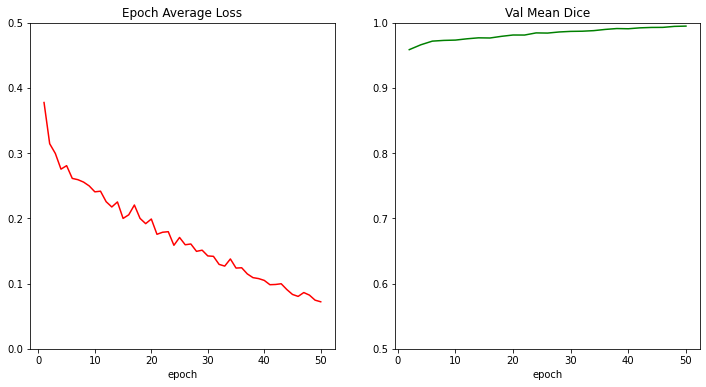

Dice in Test partition for run 40.9985028505325317
Training for run 5
----------
epoch 1/10
1/6, train_loss: 0.6102
2/6, train_loss: 0.6198
3/6, train_loss: 0.5692
4/6, train_loss: 0.5492
5/6, train_loss: 0.5307
6/6, train_loss: 0.5519
7/6, train_loss: 0.5105
epoch 1 average loss: 0.5631
----------
epoch 2/10
1/6, train_loss: 0.5319
2/6, train_loss: 0.5562
3/6, train_loss: 0.5433
4/6, train_loss: 0.5235
5/6, train_loss: 0.5707
6/6, train_loss: 0.4943
7/6, train_loss: 0.4785
epoch 2 average loss: 0.5283
saved new best metric model
current epoch: 2 current mean dice: 0.7739 best mean dice: 0.7739 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.5406
2/6, train_loss: 0.5265
3/6, train_loss: 0.5170
4/6, train_loss: 0.5225
5/6, train_loss: 0.5041
6/6, train_loss: 0.5135
7/6, train_loss: 0.5173
epoch 3 average loss: 0.5202
----------
epoch 4/10
1/6, train_loss: 0.5019
2/6, train_loss: 0.5417
3/6, train_loss: 0.5160
4/6, train_loss: 0.4848
5/6, train_loss: 0.5108
6/6, train_loss: 0.5052
7/

1/6, train_loss: 0.2436
2/6, train_loss: 0.2201
3/6, train_loss: 0.2653
4/6, train_loss: 0.2084
5/6, train_loss: 0.2353
6/6, train_loss: 0.2333
7/6, train_loss: 0.2209
epoch 31 average loss: 0.2324
----------
epoch 32/10
1/6, train_loss: 0.2166
2/6, train_loss: 0.2399
3/6, train_loss: 0.1993
4/6, train_loss: 0.2157
5/6, train_loss: 0.2168
6/6, train_loss: 0.2070
7/6, train_loss: 0.3177
epoch 32 average loss: 0.2304
saved new best metric model
current epoch: 32 current mean dice: 0.9960 best mean dice: 0.9960 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.2238
2/6, train_loss: 0.2124
3/6, train_loss: 0.2384
4/6, train_loss: 0.2197
5/6, train_loss: 0.2165
6/6, train_loss: 0.2141
7/6, train_loss: 0.2943
epoch 33 average loss: 0.2313
----------
epoch 34/10
1/6, train_loss: 0.2329
2/6, train_loss: 0.1905
3/6, train_loss: 0.2066
4/6, train_loss: 0.2232
5/6, train_loss: 0.2194
6/6, train_loss: 0.2286
7/6, train_loss: 0.2245
epoch 34 average loss: 0.2180
saved new best metric model
curr

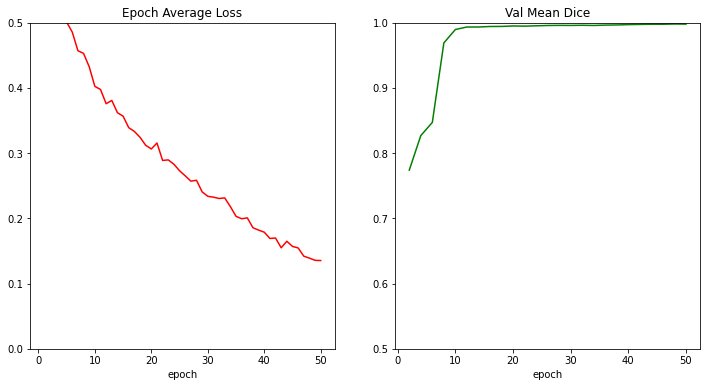

Dice in Test partition for run 50.9992395639419556
Training for run 6
----------
epoch 1/10
1/6, train_loss: 0.5683
2/6, train_loss: 0.5566
3/6, train_loss: 0.5290
4/6, train_loss: 0.4520
5/6, train_loss: 0.5109
6/6, train_loss: 0.4707
7/6, train_loss: 0.5205
epoch 1 average loss: 0.5154
----------
epoch 2/10
1/6, train_loss: 0.5391
2/6, train_loss: 0.4687
3/6, train_loss: 0.4547
4/6, train_loss: 0.4352
5/6, train_loss: 0.4968
6/6, train_loss: 0.4625
7/6, train_loss: 0.4762
epoch 2 average loss: 0.4762
saved new best metric model
current epoch: 2 current mean dice: 0.7887 best mean dice: 0.7887 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.4546
2/6, train_loss: 0.4862
3/6, train_loss: 0.4393
4/6, train_loss: 0.4811
5/6, train_loss: 0.4865
6/6, train_loss: 0.4280
7/6, train_loss: 0.5048
epoch 3 average loss: 0.4687
----------
epoch 4/10
1/6, train_loss: 0.4420
2/6, train_loss: 0.4454
3/6, train_loss: 0.4281
4/6, train_loss: 0.4388
5/6, train_loss: 0.4752
6/6, train_loss: 0.4938
7/

1/6, train_loss: 0.2035
2/6, train_loss: 0.2469
3/6, train_loss: 0.2290
4/6, train_loss: 0.2064
5/6, train_loss: 0.2106
6/6, train_loss: 0.1838
7/6, train_loss: 0.1898
epoch 31 average loss: 0.2100
----------
epoch 32/10
1/6, train_loss: 0.2117
2/6, train_loss: 0.2208
3/6, train_loss: 0.1828
4/6, train_loss: 0.2395
5/6, train_loss: 0.1688
6/6, train_loss: 0.1997
7/6, train_loss: 0.2559
epoch 32 average loss: 0.2113
saved new best metric model
current epoch: 32 current mean dice: 0.9788 best mean dice: 0.9788 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.2154
2/6, train_loss: 0.1968
3/6, train_loss: 0.2001
4/6, train_loss: 0.2243
5/6, train_loss: 0.2304
6/6, train_loss: 0.1886
7/6, train_loss: 0.1826
epoch 33 average loss: 0.2055
----------
epoch 34/10
1/6, train_loss: 0.2179
2/6, train_loss: 0.1705
3/6, train_loss: 0.1766
4/6, train_loss: 0.1521
5/6, train_loss: 0.1883
6/6, train_loss: 0.2454
7/6, train_loss: 0.1348
epoch 34 average loss: 0.1837
saved new best metric model
curr

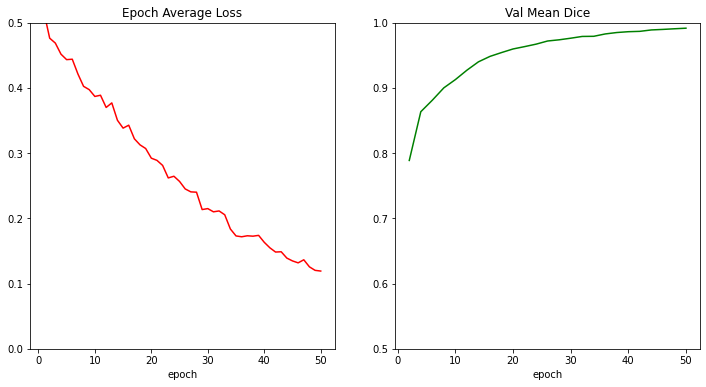

Dice in Test partition for run 60.9961664080619812
Training for run 7
----------
epoch 1/10
1/6, train_loss: 0.5830
2/6, train_loss: 0.5634
3/6, train_loss: 0.5735
4/6, train_loss: 0.5412
5/6, train_loss: 0.4756
6/6, train_loss: 0.4976
7/6, train_loss: 0.5032
epoch 1 average loss: 0.5339
----------
epoch 2/10
1/6, train_loss: 0.5246
2/6, train_loss: 0.4885
3/6, train_loss: 0.4403
4/6, train_loss: 0.4719
5/6, train_loss: 0.5134
6/6, train_loss: 0.4714
7/6, train_loss: 0.4667
epoch 2 average loss: 0.4824
saved new best metric model
current epoch: 2 current mean dice: 0.8873 best mean dice: 0.8873 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.4761
2/6, train_loss: 0.4501
3/6, train_loss: 0.4600
4/6, train_loss: 0.4761
5/6, train_loss: 0.4300
6/6, train_loss: 0.4509
7/6, train_loss: 0.5091
epoch 3 average loss: 0.4646
----------
epoch 4/10
1/6, train_loss: 0.4778
2/6, train_loss: 0.4661
3/6, train_loss: 0.4578
4/6, train_loss: 0.4566
5/6, train_loss: 0.4322
6/6, train_loss: 0.4119
7/

1/6, train_loss: 0.2214
2/6, train_loss: 0.1948
3/6, train_loss: 0.2433
4/6, train_loss: 0.2098
5/6, train_loss: 0.2007
6/6, train_loss: 0.2065
7/6, train_loss: 0.2299
epoch 31 average loss: 0.2152
----------
epoch 32/10
1/6, train_loss: 0.2016
2/6, train_loss: 0.1934
3/6, train_loss: 0.2134
4/6, train_loss: 0.2126
5/6, train_loss: 0.2087
6/6, train_loss: 0.2137
7/6, train_loss: 0.1955
epoch 32 average loss: 0.2055
saved new best metric model
current epoch: 32 current mean dice: 0.9883 best mean dice: 0.9885 at epoch 30
----------
epoch 33/10
1/6, train_loss: 0.2205
2/6, train_loss: 0.2020
3/6, train_loss: 0.2301
4/6, train_loss: 0.2040
5/6, train_loss: 0.1931
6/6, train_loss: 0.1887
7/6, train_loss: 0.2341
epoch 33 average loss: 0.2104
----------
epoch 34/10
1/6, train_loss: 0.1953
2/6, train_loss: 0.1989
3/6, train_loss: 0.1978
4/6, train_loss: 0.1968
5/6, train_loss: 0.2576
6/6, train_loss: 0.1919
7/6, train_loss: 0.2192
epoch 34 average loss: 0.2082
saved new best metric model
curr

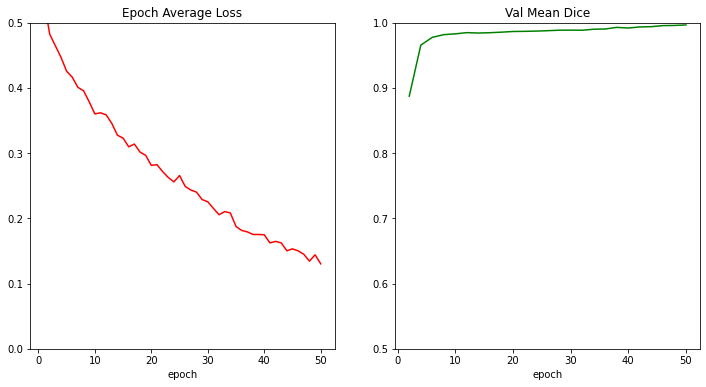

Dice in Test partition for run 70.997968852519989
Training for run 8
----------
epoch 1/10
1/6, train_loss: 0.5686
2/6, train_loss: 0.4873
3/6, train_loss: 0.4367
4/6, train_loss: 0.3985
5/6, train_loss: 0.4033
6/6, train_loss: 0.3795
7/6, train_loss: 0.3425
epoch 1 average loss: 0.4309
----------
epoch 2/10
1/6, train_loss: 0.4346
2/6, train_loss: 0.3880
3/6, train_loss: 0.3521
4/6, train_loss: 0.3770
5/6, train_loss: 0.3506
6/6, train_loss: 0.3784
7/6, train_loss: 0.3465
epoch 2 average loss: 0.3753
saved new best metric model
current epoch: 2 current mean dice: 0.9282 best mean dice: 0.9282 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.3304
2/6, train_loss: 0.3063
3/6, train_loss: 0.3391
4/6, train_loss: 0.3694
5/6, train_loss: 0.3416
6/6, train_loss: 0.3637
7/6, train_loss: 0.3310
epoch 3 average loss: 0.3402
----------
epoch 4/10
1/6, train_loss: 0.3391
2/6, train_loss: 0.3058
3/6, train_loss: 0.3279
4/6, train_loss: 0.3207
5/6, train_loss: 0.3348
6/6, train_loss: 0.3240
7/6

1/6, train_loss: 0.1341
2/6, train_loss: 0.1515
3/6, train_loss: 0.1460
4/6, train_loss: 0.1907
5/6, train_loss: 0.1908
6/6, train_loss: 0.1587
7/6, train_loss: 0.1068
epoch 31 average loss: 0.1541
----------
epoch 32/10
1/6, train_loss: 0.1827
2/6, train_loss: 0.1952
3/6, train_loss: 0.1546
4/6, train_loss: 0.1907
5/6, train_loss: 0.1427
6/6, train_loss: 0.1319
7/6, train_loss: 0.1264
epoch 32 average loss: 0.1606
saved new best metric model
current epoch: 32 current mean dice: 0.9799 best mean dice: 0.9799 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.1508
2/6, train_loss: 0.1223
3/6, train_loss: 0.1667
4/6, train_loss: 0.1412
5/6, train_loss: 0.1955
6/6, train_loss: 0.1452
7/6, train_loss: 0.2610
epoch 33 average loss: 0.1690
----------
epoch 34/10
1/6, train_loss: 0.1854
2/6, train_loss: 0.1466
3/6, train_loss: 0.1597
4/6, train_loss: 0.1255
5/6, train_loss: 0.1432
6/6, train_loss: 0.1250
7/6, train_loss: 0.1389
epoch 34 average loss: 0.1463
saved new best metric model
curr

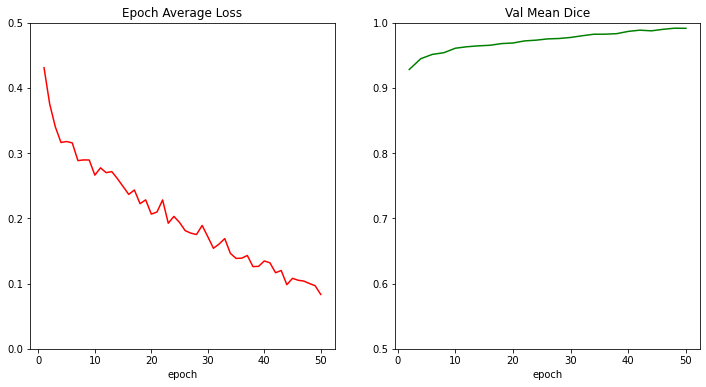

Dice in Test partition for run 80.9972450137138367
Training for run 9
----------
epoch 1/10
1/6, train_loss: 0.5292
2/6, train_loss: 0.5234
3/6, train_loss: 0.5116
4/6, train_loss: 0.4654
5/6, train_loss: 0.4398
6/6, train_loss: 0.4679
7/6, train_loss: 0.4572
epoch 1 average loss: 0.4849
----------
epoch 2/10
1/6, train_loss: 0.4517
2/6, train_loss: 0.4472
3/6, train_loss: 0.4383
4/6, train_loss: 0.4262
5/6, train_loss: 0.4066
6/6, train_loss: 0.4190
7/6, train_loss: 0.4024
epoch 2 average loss: 0.4273
saved new best metric model
current epoch: 2 current mean dice: 0.9315 best mean dice: 0.9315 at epoch 2
----------
epoch 3/10
1/6, train_loss: 0.3943
2/6, train_loss: 0.4213
3/6, train_loss: 0.4144
4/6, train_loss: 0.3792
5/6, train_loss: 0.3967
6/6, train_loss: 0.3991
7/6, train_loss: 0.4487
epoch 3 average loss: 0.4077
----------
epoch 4/10
1/6, train_loss: 0.3894
2/6, train_loss: 0.3742
3/6, train_loss: 0.3786
4/6, train_loss: 0.3886
5/6, train_loss: 0.3939
6/6, train_loss: 0.4057
7/

1/6, train_loss: 0.2187
2/6, train_loss: 0.1787
3/6, train_loss: 0.2216
4/6, train_loss: 0.2451
5/6, train_loss: 0.2124
6/6, train_loss: 0.1787
7/6, train_loss: 0.2137
epoch 31 average loss: 0.2098
----------
epoch 32/10
1/6, train_loss: 0.1840
2/6, train_loss: 0.2069
3/6, train_loss: 0.1836
4/6, train_loss: 0.2297
5/6, train_loss: 0.1984
6/6, train_loss: 0.1965
7/6, train_loss: 0.1681
epoch 32 average loss: 0.1953
saved new best metric model
current epoch: 32 current mean dice: 0.9798 best mean dice: 0.9798 at epoch 32
----------
epoch 33/10
1/6, train_loss: 0.1833
2/6, train_loss: 0.1623
3/6, train_loss: 0.1672
4/6, train_loss: 0.1681
5/6, train_loss: 0.2239
6/6, train_loss: 0.2040
7/6, train_loss: 0.2495
epoch 33 average loss: 0.1940
----------
epoch 34/10
1/6, train_loss: 0.1804
2/6, train_loss: 0.1842
3/6, train_loss: 0.2215
4/6, train_loss: 0.2103
5/6, train_loss: 0.2142
6/6, train_loss: 0.1428
7/6, train_loss: 0.1932
epoch 34 average loss: 0.1924
saved new best metric model
curr

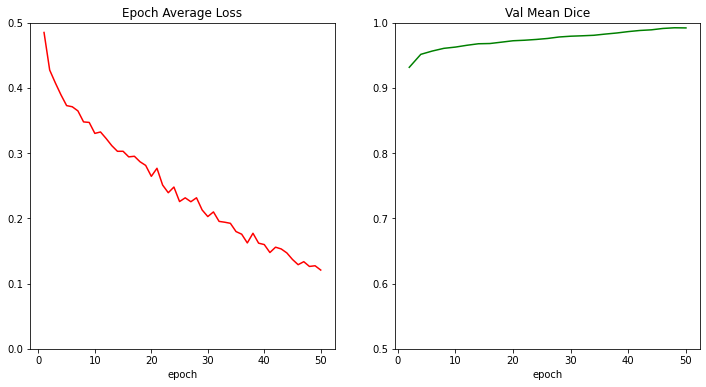

Dice in Test partition for run 90.9975746870040894


In [73]:
best_val_performances = []
test_performances = []
file_performances_test = open( OUTPUT+ 'performances_dice_'+EXPERIMENT.split('/')[0]+'.txt','w')
epocs = 50
runs = 10
for run_num in range(runs):
    print(f"Training for run {run_num}")
    model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128),
        strides=(2, 2, 2),
        num_res_units=2,
    ).to(device)

    loss_function = monai.losses.DiceLoss(sigmoid=True)
    optimizer     = torch.optim.Adam(model.parameters(), 1e-3)

    # start a typical PyTorch training
    val_interval = 2
    best_metric  = -1
    best_metric_epoch = -1
    
    epoch_loss_values  = list()
    metric_values      = list()
    metric_values_test = list()
    writer = SummaryWriter()
    
    for epoch in range(epocs):
        
        print("-" * 10)
        print(f"epoch {epoch + 1}/{10}")
        model.train()
        epoch_loss = 0
        step = 0
        
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_len   = len(train_ds) // train_loader.batch_size
            
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
            
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        if (epoch + 1) % val_interval == 0:
            model.eval()
            
            with torch.no_grad():
                val_images  = None
                val_labels  = None
                val_outputs = None
                
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    roi_size = (96, 96)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    #print("========")
                    #print(val_outputs[0].shape,val_labels[0].shape)
                    dice_metric(y_pred=val_outputs, y=val_labels)
                    #print("========")

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()
                metric_values.append(metric)
                
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    
                    torch.save(model.state_dict(),ROOT_EXP+"/models/"+EXPERIMENT+"run_" +str(run_num)+"_best_metric_model_segmentation2d_array.pth")
                   
                print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_mean_dice", metric, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")
    
    best_val_performances.append(best_metric)
    
    
    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Epoch Average Loss")
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.plot(x, y, color="red")
    plt.ylim([0.,0.5])
    plt.subplot(1, 2, 2)
    plt.title("Val Mean Dice")
    x = [val_interval * (i + 1) for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel("epoch")
    plt.plot(x, y, color="green")
    plt.ylim([0.5,1])
    plt.savefig(OUTPUT+ f'trainin_dice_run_{run_num}_'+EXPERIMENT.split('/')[0]+'.jpg')
    plt.show()


    #Evaluation in the test partition
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        roi_size = (96, 96)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_images, roi_size, sw_batch_size, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
        dice_metric_test(y_pred=test_outputs, y=test_labels)
    metric_test = dice_metric_test.aggregate().item()
    
    dice_metric_test.reset()
    test_performances.append(metric_test)
    print("Dice in Test partition for run " + str(run_num) + str(metric_test))
    file_performances_test.write(str(metric_test)+'\n')
    
    
    
file_performances_test.close()

In [74]:
metric_values

[0.9314988255500793,
 0.9514020681381226,
 0.9564828872680664,
 0.9605998992919922,
 0.9625204205513,
 0.9652951955795288,
 0.967624843120575,
 0.9679939150810242,
 0.9700810313224792,
 0.9722210168838501,
 0.9730283617973328,
 0.9742165803909302,
 0.975750744342804,
 0.9780114889144897,
 0.9791963696479797,
 0.9798398017883301,
 0.9806103706359863,
 0.9824730157852173,
 0.9841383099555969,
 0.9862739443778992,
 0.9879881143569946,
 0.9889755249023438,
 0.9910895228385925,
 0.992118239402771,
 0.991908848285675]

In [75]:
test_performances

[0.9980753660202026,
 0.9975147247314453,
 0.9951815605163574,
 0.9979149699211121,
 0.9985028505325317,
 0.9992395639419556,
 0.9961664080619812,
 0.997968852519989,
 0.9972450137138367,
 0.9975746870040894]

In [76]:
best_val_performances

[0.9907679557800293,
 0.9925140142440796,
 0.985445499420166,
 0.9917953610420227,
 0.9946869015693665,
 0.9978987574577332,
 0.9914924502372742,
 0.9964829683303833,
 0.9914762377738953,
 0.992118239402771]

# Second Silo (Circles)

In [77]:
imagepaths_train  = sorted(glob(os.path.join(train_dir, "circle*img*.png")))
segmpaths_train   = sorted(glob(os.path.join(train_dir, "circle*seg*.png")))
print(len(imagepaths_train),len(segmpaths_train))

imagepaths_val  = sorted(glob(os.path.join(val_dir, "circle*img*.png")))
segmpaths_val   = sorted(glob(os.path.join(val_dir, "circle*seg*.png")))
print(len(imagepaths_val),len(segmpaths_val))

imagepaths_test  = sorted(glob(os.path.join(test_dir, "*img*.png")))
segmpaths_test   = sorted(glob(os.path.join(test_dir, "*seg*.png")))
print(len(imagepaths_test),len(segmpaths_test))

OUTPUT = ROOT_EXP + 'results_distributed_circles/'

if(not isdir(OUTPUT)):
    mkdir(OUTPUT)
    

65 65
5 5
20 20


In [78]:
# define transforms for image and segmentation
train_imtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)
train_segtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)

In [79]:
val_imtrans  = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])
val_segtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

# define array dataset, data loader
check_ds     =    ArrayDataset(imagepaths_train, train_imtrans, segmpaths_train, train_segtrans)
check_loader = DataLoader(check_ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg      =  monai.utils.misc.first(check_loader)
print(im.shape, seg.shape)

torch.Size([10, 1, 96, 96]) torch.Size([10, 1, 96, 96])


In [80]:
# create a training data loader
train_ds = ArrayDataset(imagepaths_train, train_imtrans, segmpaths_train, train_segtrans)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available()
                         )
# create a validation data loader
val_ds = ArrayDataset(imagepaths_val, val_imtrans, segmpaths_val, val_segtrans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())

#create the test data loader
test_ds = ArrayDataset(imagepaths_test, val_imtrans, segmpaths_test, val_segtrans)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
dice_metric_test = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)


post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


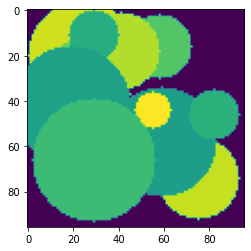

In [81]:
plt.imshow(train_ds[0][0][0].cpu())

Training for run 0
----------
epoch 1/10
1/16, train_loss: 0.4461
2/16, train_loss: 0.4479
3/16, train_loss: 0.3967
4/16, train_loss: 0.4290
5/16, train_loss: 0.3988
6/16, train_loss: 0.4129
7/16, train_loss: 0.4557
8/16, train_loss: 0.4010
9/16, train_loss: 0.3998
10/16, train_loss: 0.4074
11/16, train_loss: 0.3515
12/16, train_loss: 0.3809
13/16, train_loss: 0.3900
14/16, train_loss: 0.3691
15/16, train_loss: 0.4063
16/16, train_loss: 0.3725
17/16, train_loss: 0.4016
epoch 1 average loss: 0.4040
----------
epoch 2/10
1/16, train_loss: 0.3939
2/16, train_loss: 0.3906
3/16, train_loss: 0.3899
4/16, train_loss: 0.4033
5/16, train_loss: 0.3567
6/16, train_loss: 0.3519
7/16, train_loss: 0.3476
8/16, train_loss: 0.4178
9/16, train_loss: 0.3696
10/16, train_loss: 0.3694
11/16, train_loss: 0.3837
12/16, train_loss: 0.3576
13/16, train_loss: 0.3745
14/16, train_loss: 0.3638
15/16, train_loss: 0.3353
16/16, train_loss: 0.3647
17/16, train_loss: 0.3668
epoch 2 average loss: 0.3728
saved new bes

saved new best metric model
current epoch: 16 current mean dice: 0.9993 best mean dice: 0.9993 at epoch 16
----------
epoch 17/10
1/16, train_loss: 0.1232
2/16, train_loss: 0.1188
3/16, train_loss: 0.1507
4/16, train_loss: 0.1244
5/16, train_loss: 0.1273
6/16, train_loss: 0.1157
7/16, train_loss: 0.1234
8/16, train_loss: 0.1250
9/16, train_loss: 0.1220
10/16, train_loss: 0.1650
11/16, train_loss: 0.1079
12/16, train_loss: 0.1283
13/16, train_loss: 0.1224
14/16, train_loss: 0.1120
15/16, train_loss: 0.1200
16/16, train_loss: 0.1360
17/16, train_loss: 0.1067
epoch 17 average loss: 0.1252
----------
epoch 18/10
1/16, train_loss: 0.1131
2/16, train_loss: 0.1451
3/16, train_loss: 0.1027
4/16, train_loss: 0.1177
5/16, train_loss: 0.1373
6/16, train_loss: 0.1289
7/16, train_loss: 0.1164
8/16, train_loss: 0.1195
9/16, train_loss: 0.1031
10/16, train_loss: 0.1159
11/16, train_loss: 0.1160
12/16, train_loss: 0.1116
13/16, train_loss: 0.1066
14/16, train_loss: 0.1264
15/16, train_loss: 0.1002
16/

saved new best metric model
current epoch: 32 current mean dice: 0.9998 best mean dice: 0.9998 at epoch 32
----------
epoch 33/10
1/16, train_loss: 0.0528
2/16, train_loss: 0.0492
3/16, train_loss: 0.0494
4/16, train_loss: 0.0425
5/16, train_loss: 0.0541
6/16, train_loss: 0.0382
7/16, train_loss: 0.0357
8/16, train_loss: 0.0424
9/16, train_loss: 0.0372
10/16, train_loss: 0.0455
11/16, train_loss: 0.0510
12/16, train_loss: 0.0425
13/16, train_loss: 0.0370
14/16, train_loss: 0.0447
15/16, train_loss: 0.0410
16/16, train_loss: 0.0397
17/16, train_loss: 0.0349
epoch 33 average loss: 0.0434
----------
epoch 34/10
1/16, train_loss: 0.0370
2/16, train_loss: 0.0379
3/16, train_loss: 0.0470
4/16, train_loss: 0.0337
5/16, train_loss: 0.0498
6/16, train_loss: 0.0583
7/16, train_loss: 0.0400
8/16, train_loss: 0.0367
9/16, train_loss: 0.0390
10/16, train_loss: 0.0353
11/16, train_loss: 0.0477
12/16, train_loss: 0.0353
13/16, train_loss: 0.0376
14/16, train_loss: 0.0661
15/16, train_loss: 0.0450
16/

saved new best metric model
current epoch: 48 current mean dice: 0.9999 best mean dice: 0.9999 at epoch 44
----------
epoch 49/10
1/16, train_loss: 0.0186
2/16, train_loss: 0.0281
3/16, train_loss: 0.0186
4/16, train_loss: 0.0209
5/16, train_loss: 0.0228
6/16, train_loss: 0.0218
7/16, train_loss: 0.0202
8/16, train_loss: 0.0193
9/16, train_loss: 0.0226
10/16, train_loss: 0.0223
11/16, train_loss: 0.0434
12/16, train_loss: 0.0254
13/16, train_loss: 0.0255
14/16, train_loss: 0.0341
15/16, train_loss: 0.0275
16/16, train_loss: 0.0202
17/16, train_loss: 0.0375
epoch 49 average loss: 0.0252
----------
epoch 50/10
1/16, train_loss: 0.0170
2/16, train_loss: 0.0187
3/16, train_loss: 0.0218
4/16, train_loss: 0.0256
5/16, train_loss: 0.0180
6/16, train_loss: 0.0190
7/16, train_loss: 0.0177
8/16, train_loss: 0.0227
9/16, train_loss: 0.0185
10/16, train_loss: 0.0261
11/16, train_loss: 0.0243
12/16, train_loss: 0.0214
13/16, train_loss: 0.0217
14/16, train_loss: 0.0383
15/16, train_loss: 0.0327
16/

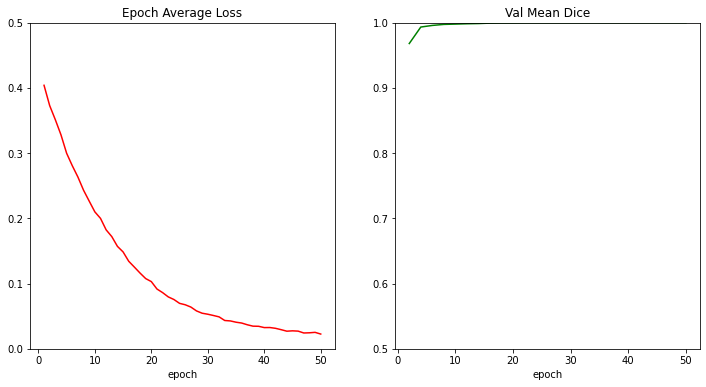

Dice in Test partition for run 00.9994680285453796


In [84]:
best_val_performances = []
test_performances = []
file_performances_test = open( OUTPUT+ 'performances_dice_'+EXPERIMENT.split('/')[0]+'.txt','w')
epocs = 50
runs = 1
for run_num in range(runs):
    print(f"Training for run {run_num}")
    model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128),
        strides=(2, 2, 2),
        num_res_units=2,
    ).to(device)

    loss_function = monai.losses.DiceLoss(sigmoid=True)
    optimizer     = torch.optim.Adam(model.parameters(), 1e-3)

    # start a typical PyTorch training
    val_interval = 2
    best_metric  = -1
    best_metric_epoch = -1
    
    epoch_loss_values  = list()
    metric_values      = list()
    metric_values_test = list()
    writer = SummaryWriter()
    
    for epoch in range(epocs):
        
        print("-" * 10)
        print(f"epoch {epoch + 1}/{10}")
        model.train()
        epoch_loss = 0
        step = 0
        
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_len   = len(train_ds) // train_loader.batch_size
            
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
            
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        if (epoch + 1) % val_interval == 0:
            model.eval()
            
            with torch.no_grad():
                val_images  = None
                val_labels  = None
                val_outputs = None
                
                for val_data in val_loader:
                    
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    
                    #val_images, val_labels = val_data[np.newaxis,:].to(device), val_data[1][np.newaxis,:].to(device)
                    
                    roi_size = (96, 96)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    #print("========")
                    #print(val_outputs[0].shape,val_labels[0].shape)
                    dice_metric(y_pred=val_outputs, y=val_labels)
                    #print("========")

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()
                metric_values.append(metric)
                
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    
                    torch.save(model.state_dict(),ROOT_EXP+"/models/"+EXPERIMENT+"run_" +str(run_num)+"_best_metric_model_segmentation2d_array.pth")
                   
                print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_mean_dice", metric, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")
    
    best_val_performances.append(best_metric)
    
    
    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Epoch Average Loss")
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.plot(x, y, color="red")
    plt.ylim([0.,0.5])
    plt.subplot(1, 2, 2)
    plt.title("Val Mean Dice")
    x = [val_interval * (i + 1) for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel("epoch")
    plt.plot(x, y, color="green")
    plt.ylim([0.5,1])
    plt.savefig(OUTPUT+ f'trainin_dice_run_{run_num}_'+EXPERIMENT.split('/')[0]+'.jpg')
    plt.show()


    #Evaluation in the test partition
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        roi_size = (96, 96)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_images, roi_size, sw_batch_size, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
        dice_metric_test(y_pred=test_outputs, y=test_labels)
    metric_test = dice_metric_test.aggregate().item()
    
    dice_metric_test.reset()
    test_performances.append(metric_test)
    print("Dice in Test partition for run " + str(run_num) + str(metric_test))
    file_performances_test.write(str(metric_test)+'\n')
    
    
    
file_performances_test.close()

In [61]:
test_performances

[0.9987756609916687,
 0.9990277290344238,
 0.998649001121521,
 0.9993247985839844,
 0.999156653881073,
 0.9985172152519226,
 0.9993299245834351,
 0.9985048174858093,
 0.9985248446464539,
 0.9987583160400391]

In [62]:
best_val_performances

[0.9998194575309753,
 0.9998797178268433,
 0.9998794794082642,
 0.9999086260795593,
 0.999864399433136,
 0.9997309446334839,
 0.9998943209648132,
 0.999849796295166,
 0.9997898936271667,
 0.999893844127655]